# Introduction to Tensorflow
Estimated time: 1:30 hours

## Importing necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tarfile
import requests
import re
%matplotlib inline

In [2]:
# Checking if a GPU is available
try:
    assert tf.test.is_gpu_available()
    print("You have Tensorflow {}".format(tf.__version__))
except Exception as ex:
    print(ex)
    raise AssertionError("A GPU was not detected. If your computer does not have a GPU, ignore this message")

You have Tensorflow 2.0.0


## Good old Python vs TensorFlow

In [3]:
mat_size = 2500

# Python/Numpy function
def numpy_dot(a,b):
    return np.dot(a,b)

# TensorFlow function
@tf.function
def tf_dot(a,b):
    tf_a = tf.convert_to_tensor(a, dtype=tf.float32)
    tf_b = tf.convert_to_tensor(b, dtype=tf.float32)
    
    return tf.matmul(tf_a,tf_b)
    
# Defining matrices
a = np.random.normal(size=(mat_size, mat_size)).astype(np.float32)
b = np.random.normal(size=(mat_size, mat_size)).astype(np.float32)

# Timing different operations
np_time = %timeit -o numpy_dot(a,b)
tf_time1 = %timeit -n 1 -r 1 -o tf_dot(a,b)
tf_time2 = %timeit -n 1 -r 1 -o tf_dot(a,b)
tf_time3 = %timeit -o tf_dot(a,b)

print("Numpy took {:.1f}x times more time than )1st) TensorFlow".format(np_time.best*1.0/tf_time1.best))
print("Numpy took {:.1f}x times more time than (2nd) TensorFlow".format(np_time.best*1.0/tf_time2.best))
print("Numpy took {:.1f}x times more time than (3rd onwards) TensorFlow".format(np_time.best*1.0/tf_time3.best))

392 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.45 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
77.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
88.1 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy took 0.2x times more time than )1st) TensorFlow
Numpy took 4.3x times more time than (2nd) TensorFlow
Numpy took 3.9x times more time than (3rd onwards) TensorFlow


## Numpy is very slow (for large matrices)

Not just matrix multiplication, but also other operations like convolution which are ubiquotous in neural networks. This is where TensorFlow fits in. Tensorflow has highly GPU-optimized CUDA kernels for these operations which allows TensorFlow to exploit the parallel computation power of GPUs. Where a very good CPU might be able to run 128 threads (vectorized and hyper-threaded) simultaneously, NVIDIA GTX 1080 has 2560 cores.

matrix multiplication parallel image

## Why use TensorFlow?

> TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications.

* Efficiently leverages the explicit parallel nature of GPUs to perform parallelizable computations quickly
* Has almost all the high-level functions you will need to implement simple or complex neural network
* Provides automatic differentiation so you don't have to write the backward pass of neural networks


## Downloading and exploring the dataset

Here, we are going to use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. MNIST is a labelled set of handwritten digit dataset. There are 70000 images and 70000 labels (from 0-9). Each image is black and white and is `28x28`.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Train dataset: X: {}, Y: {}".format(x_train.shape, y_train.shape))
print("Test dataset: X: {}, Y: {}".format(x_test.shape, y_test.shape))

# Checking the range of values in X
print("\nX has values between {} and {}".format(np.min(x_train), np.max(x_train)))
# Checking how many labels are there
print("\nY has following labels and counts \n{}".format(pd.Series(y_train).value_counts()))

Train dataset: X: (60000, 28, 28), Y: (60000,)
Test dataset: X: (10000, 28, 28), Y: (10000,)

X has values between 0 and 255

Y has following labels and counts 
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64


## Preprocessing the data

We will be feeding this data to a neural network and train the model to recognize hand-written digits. Before feeding the data into a model we need to perform some pre-processing. 

* We will whiten the images (i.e. compute mean of each image and subtract that from all the values of that image)
* Unwrap the image by turning 28x28 2D image to 784 1D vector
* We will convert labels to one-hot encoded vectors (e.g. `4 -> [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`)

In [5]:
from tensorflow.keras.utils import to_categorical

n_labels = 10
train_size = y_train.shape[0]
test_size = y_test.shape[0]

# Normalizing the images
x_norm_train = (x_train - np.mean(x_train, axis=(1,2), keepdims=True)).reshape(train_size, -1)
x_norm_test = (x_test - np.mean(x_test, axis=(1,2), keepdims=True)).reshape(test_size, -1)

# Onehot encoding labels
y_oh_train = to_categorical(y_train, num_classes=n_labels)
y_oh_test = to_categorical(y_test, num_classes=n_labels)

print("Train dataset: X: {}, Y: {}".format(____, ____))
print("Test dataset: X: {}, Y: {}".format(____, ____))

Train dataset: X: (60000, 784), Y: (60000, 10)
Test dataset: X: (10000, 784), Y: (10000, 10)


## Diving into TensorFlow

Here we will be exploring how we can define models using Keras. Keras offers three APIs.

* Sequential API - For building simple and straight-forward models
* Functional API - For building more complex models
* Subclassing API - For building custom models and layers

## Keras sequential API

Here we will define a model with the Keras *Sequential API*. Keras sequential API is one of the simplest APIs for implementing models. You first define a `Sequential()` object and add layers using `.add()` function. Below we are defining a 3 layer neural network.

In [6]:
from tensorflow.keras import layers, models

n_in = 784 # Number of inputs 28x28
n_out = 10 # Number of labels (digits)

# Creating a sequential model with 3 layers
# Two layers have relu activation
# The last layer has a softmax activation
model1 = models.Sequential()
model1.add(layers.Dense(100, activation='relu', input_shape=(n_in,)))
# Add another dense layer with 50 nodes and activation relu
model1.add(____)
model1.add(layers.Dense(n_out, activation='softmax'))

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# Printing out the summary
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


## Training and evaluating the model

The model training is done using `.fit()` method. You first need to pass `x` (i.e. whitened and reshaped images) and `y` (i.e. one hot encoded labels) in that order. 

In [7]:
history1 = model1.fit(x_norm_train, y_oh_train, epochs=10, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 9s 184us/sample - loss: 1.6047 - acc: 0.7891 - val_loss: 0.4378 - val_acc: 0.8777
Epoch 2/10
48000/48000 [==============================] - 8s 171us/sample - loss: 0.4133 - acc: 0.8928 - val_loss: 0.3540 - val_acc: 0.9012
Epoch 3/10
48000/48000 [==============================] - 8s 175us/sample - loss: 0.2947 - acc: 0.9214 - val_loss: 0.2881 - val_acc: 0.9255
Epoch 4/10
48000/48000 [==============================] - 8s 168us/sample - loss: 0.2330 - acc: 0.9378 - val_loss: 0.2134 - val_acc: 0.9457
Epoch 5/10
48000/48000 [==============================] - 8s 167us/sample - loss: 0.1925 - acc: 0.9474 - val_loss: 0.1871 - val_acc: 0.9548
Epoch 6/10
48000/48000 [==============================] - 8s 175us/sample - loss: 0.1674 - acc: 0.9554 - val_loss: 0.1907 - val_acc: 0.9530
Epoch 7/10
48000/48000 [==============================] - 7s 155us/sample - loss: 0.1486 - acc: 0.9593 - val_l

## Testing the model

In [8]:
test_res1 = model1.evaluate(x_norm_test, y_oh_test, verbose=0)
print("Test loss: {} , Test accuracy: {}".format(test_res1[0], test_res1[1]))

Test loss: 0.21428872477915137 , Test accuracy: 0.9484999775886536


## Printing some of the history of training

In [9]:
print("History object records {}".format(history1.history.keys()))
print("For example, validation accuracy: {}".format(history1.history.get('val_acc')))

History object records dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])
For example, validation accuracy: [0.87766665, 0.9011667, 0.9255, 0.94575, 0.9548333, 0.953, 0.95175, 0.95708334, 0.96208334, 0.9505]


## Creating more complex models with Keras

### Generating PCA features

In [10]:
from sklearn.decomposition import PCA

n_pca = 3
pca = PCA(n_components=n_pca,random_state=100)
x_pca_train = pca.fit_transform(x_norm_train)
x_pca_test = pca.transform(x_norm_test)
print(x_pca_train.shape)

(60000, 3)


### Creating the model

Can you draw this model on a piece of paper?

In [11]:
n_in = 784

n_out = 10

inp_1 = layers.Input(shape=(n_in,))
inp_2 = layers.Input(shape=(n_pca,))

out_1 = layers.Dense(100, activation='relu')(inp_1)
out_1 = layers.Dense(50, activation='relu')(out_1)

# Write a Dense layer with 100 nodes and activation relu which takes inp_2 as input
out_2 = layers.Dense(____)(____)
# Write a Dense layer with 50 nodes and activation relu that takes the output of the previous layer
out_2 = layers.Dense(____)(____)

out = layers.Concatenate(axis=-1)([out_1, out_2])
out = layers.Dense(n_out, activation='softmax')(out)

model2 = models.Model(inputs=[inp_1, inp_2], outputs=out)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          400         input_2[0][0]                    
______________________________________________________________________________________________

### Fitting the model

Let's now fit the model with data. Note that our model takes two inputs given as a Python list. We then train this model for 10 epochs with 20% validation data.

In [12]:
# Fill the blanks what inputs should be
inputs = [____, ____]
# Fill the blanks what outputs should be
outputs = ____
history2 = model2.fit(____, ____, epochs=10, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 11s 225us/sample - loss: 2.4141 - acc: 0.8591 - val_loss: 0.7717 - val_acc: 0.8964
Epoch 2/10
48000/48000 [==============================] - 9s 188us/sample - loss: 0.4566 - acc: 0.9182 - val_loss: 0.3253 - val_acc: 0.9365
Epoch 3/10
48000/48000 [==============================] - 9s 188us/sample - loss: 0.2605 - acc: 0.9352 - val_loss: 0.2510 - val_acc: 0.9383
Epoch 4/10
48000/48000 [==============================] - 9s 188us/sample - loss: 0.2043 - acc: 0.9442 - val_loss: 0.2685 - val_acc: 0.9339
Epoch 5/10
48000/48000 [==============================] - 10s 199us/sample - loss: 0.1812 - acc: 0.9489 - val_loss: 0.2102 - val_acc: 0.9450
Epoch 6/10
48000/48000 [==============================] - 10s 205us/sample - loss: 0.1613 - acc: 0.9531 - val_loss: 0.2004 - val_acc: 0.9475
Epoch 7/10
48000/48000 [==============================] - 10s 205us/sample - loss: 0.1498 - acc: 0.9579 - v

In [13]:
test_res2 = model2.evaluate([x_norm_test, x_pca_test], y_oh_test, verbose=0)
print("Test loss: {} , Test accuracy: {}".format(test_res2[0], test_res2[1]))

Test loss: 0.18194830256979913 , Test accuracy: 0.9523000121116638


## Plotting accuracies

Plotting the validation accuracy of the two models.

* Model1 - Using only images as inputs
* Model2 - Using images + PCA features as inputs


Text(0, 0.5, 'Validation accuracy')

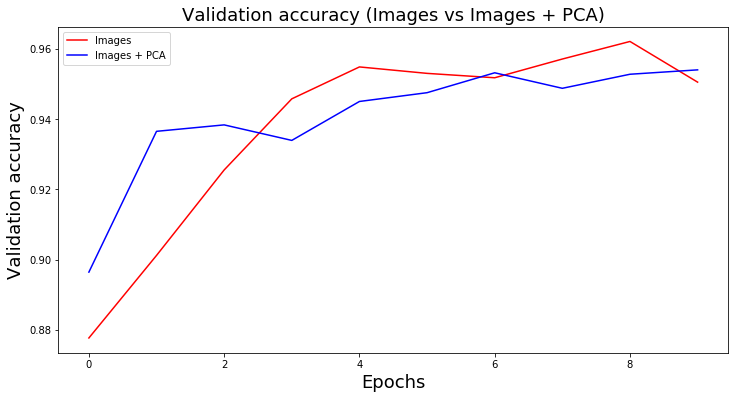

In [14]:
val1 = history1.history.get('val_acc')
val2 = history2.history.get('val_acc')

plt.figure(figsize=(12,6))
plt.plot(np.arange(len(val1)), val1, color='r', label='Images')
plt.plot(np.arange(len(val2)), val2, color='b', label='Images + PCA')
plt.legend()
plt.title("Validation accuracy (Images vs Images + PCA)", fontsize=18)
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Validation accuracy", fontsize=18)

## Processing text with TensorFlow/Keras

Tensorflow/Keras offers many objects and functions to perform text processing. Text need to be converted to some numerical representation. Here we will be using a movie review dataset to see some of those functionality in action.

In [2]:
dataset_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def download_movie_reviews(url):
    """ Downloading and loading the data """
    
    def read_tar(file):
        """ Try loading the data if it is already downloaded """
        text_data, labels = [],[]
        tar = tarfile.open(file, "r:gz")
        for member in tar.getmembers():
                
            if re.match(r"aclImdb\/train\/(?:pos|neg)\/\w+.txt",member.name):
                text = tar.extractfile(member).read().decode('utf-8')
                if member.name.startswith('aclImdb/train/pos'):
                    labels.append(1)
                    text_data.append(text)
                elif member.name.startswith('aclImdb/train/neg'):
                    labels.append(0)
                    text_data.append(text)
                else:
                    continue
                    
        return text_data, labels
    
    file = os.path.join('movie-review-data', "aclImdb_v1.tar.gz")
    
    try:
        """ Try loading the data if it is already downloaded """
        return read_tar(file)

    except FileNotFoundError:
        """ If the file is not there, download the file """
        res = requests.get(url, stream=True)
        print('Making a directory movie-review-data to store data')
        if not os.path.exists('movie-review-data'):
            os.mkdir('movie-review-data')
        with open(file, 'wb') as f:
            print('Downloading data')
            f.write(res.content)
            print('Download finished.')
        
        return read_tar(file)
        
    except Exception as ex:
        raise ex
        
orig_text_data, orig_labels = download_movie_reviews(dataset_url)
print('Found {} reviews'.format(len(orig_text_data)))
print('Found {} positive reviews and {} negative reviews'.format(
    sum(orig_labels), len(orig_labels)-sum(orig_labels))
     )

Found 25000 reviews
Found 12500 positive reviews and 12500 negative reviews


## Printing some data

Let's first print some data and see what we have got.

In [3]:
for i, (rev, lbl) in enumerate(zip(orig_text_data, orig_labels)):
    print("Review: {}".format(rev[:250]))
    print("Label: {}".format(lbl))
    if i==5: break

Review: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a 
Label: 0
Review: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that is
Label: 0
Review: If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without
Label: 0
Review: This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (

## Further analysis with pandas

We can do further analysis and preprocessing using pandas. Pandas is a very versatile library that enables us to perform complex data manipulation on numbers and strings.

In [4]:
# Converting the data we got to a pandas dataframe
df = pd.DataFrame({"text": orig_text_data, "label": orig_labels})
df.head()

,label,text
0,0,I rented I AM CURIOUS-YELLOW from my video sto...
1,0,"""I Am Curious: Yellow"" is a risible and preten..."
2,0,If only to avoid making this type of film in t...
3,0,This film was probably inspired by Godard's Ma...
4,0,"Oh, brother...after hearing about this ridicul..."


## Basic text preprocessing with pandas

Here we will be doing some basic preprocessing. This is not an exhaustive list of steps. However this would be adequate as we will not traing a model on this data, rather learn about various functions/operations available.

In [5]:
# Removing html tags and punctuation
df['text'] = df['text'].str.lower().str.replace('<br />',' ', regex=False).str.replace(r'[",:\-\(\)(?...)(?..)]',' ')
# Removing extra spaces and replacing sentence ending punctuation with periods
df['text'] = df['text'].str.replace('\s{2,}',' ').str.replace('[.!?]', ' . ')
df.head(n=10)

,label,text
0,0,i rented i am curious yellow from my video sto...
1,0,i am curious yellow is a risible and pretenti...
2,0,if only to avoid making this type of film in t...
3,0,this film was probably inspired by godard's ma...
4,0,oh brother after hearing about this ridiculous...
5,0,i would put this at the top of my list of film...
6,0,whoever wrote the screenplay for this movie ob...
7,0,when i first saw a glimpse of this movie i qui...
8,0,who are these they the actors the filmmakers c...
9,0,this is said to be a personal film for peter b...


## What is this code doing?

In [6]:
sample_df = df.sample(frac=0.1, random_state=100)
sample_text = sample_df['text'].tolist()
sample_labels = sample_df['label'].tolist()

## Most common words in positive vs negative

Let's use pandas to find out the most common words for positive and negative labels

In [20]:
def count_words(grp):
    sw_regex = "(?: with | or | we | the | a | and | of | to | is | this | in | it | i | that | but | was | for | you | are | they | have | had | as | on | he | his | so | an | be | who)"
    return pd.Series(grp.str.cat(sep=' ')).str.replace(sw_regex,"",regex=True).str.split(expand=True).iloc[0].value_counts().index[:20].tolist()

pd.options.display.max_colwidth = 200

# Perform a groupby based on the label and for each group execute count_words
grouped_by_label = sample_df.groupby('label').agg({'text':count_words})
grouped_by_label.head()

,text
label,
0,"[., not, movie, at, by, film, it's, just, no, from, one, more, even, like, her, about, some, really, good, all]"
1,"[., by, not, film, from, movie, at, it's, her, more, has, very, one, she, about, like, all, some, my, just]"


## Fitting a tokenizer

Keras offers a `Tokenizer` object which will convert words to numerical ids. Each unique word gets an unique ID. The tokenizer offers the following attributes.

* index_word - Converts an index to a word
* word_index - Converts a word to an index

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

num_words = 1000
# Implement a tokenizer that has num_words words and oov_token <unk>
tok = ____
# Fit the tokenizer on texts
tok.fit_on_texts(____)

## Converting text to number sequences

You can use `texts_to_sequences()` function to convert a list of documents to a list of sequences of integer IDs

In [22]:
# Use texts_to_sequences function to convert sample_text to sequence of IDs
sample_seqs = tok.____
print(sample_seqs[0])

[10, 148, 35, 11, 18, 55, 159, 10, 92, 1, 621, 1, 52, 74, 8, 11, 18, 23, 65, 148, 68, 457, 218, 1, 20, 2, 1, 1, 1, 3, 1, 1, 1, 1, 13, 474, 218, 5, 270, 2, 107, 8, 11, 18, 7, 629, 88, 41, 35, 12, 1, 1, 18, 9, 199, 13, 549, 8, 4, 601, 1, 1, 3, 10, 35, 2, 200, 411, 8, 9, 9, 89, 69, 278, 6, 1, 59, 202, 739, 411, 8, 357, 1, 47, 44, 176, 571, 12, 241, 43, 15, 4, 18, 3, 22, 2, 86, 528, 9, 718, 182, 12, 78, 197, 182, 95, 25, 571, 336, 584, 8, 262, 495, 44, 48, 839, 1, 70, 6, 595, 9, 77, 1, 182, 6, 26, 1, 47, 71, 647, 15, 123, 7, 22, 195, 14, 49, 20, 2, 86, 485, 14, 71, 100, 271, 47, 71, 25, 139, 7, 2, 111, 15, 182, 30, 177, 982]


In [23]:
# Printing the lengths of some sequences
for i, seq in enumerate(sample_seqs[:10]):
    print("Sequence {} is {} words long".format(i, len(seq)))

Sequence 0 is 157 words long
Sequence 1 is 147 words long
Sequence 2 is 66 words long
Sequence 3 is 83 words long
Sequence 4 is 116 words long
Sequence 5 is 113 words long
Sequence 6 is 205 words long
Sequence 7 is 583 words long
Sequence 8 is 51 words long
Sequence 9 is 79 words long


## Plotting the length of sentences

It is important to know the lengths of the sentences, as we need to fix the number of time steps of the data. That is,

* We truncate long sentences short
* We pad zeros to the short sentences

Text(0.5, 0, 'Sentence ID')

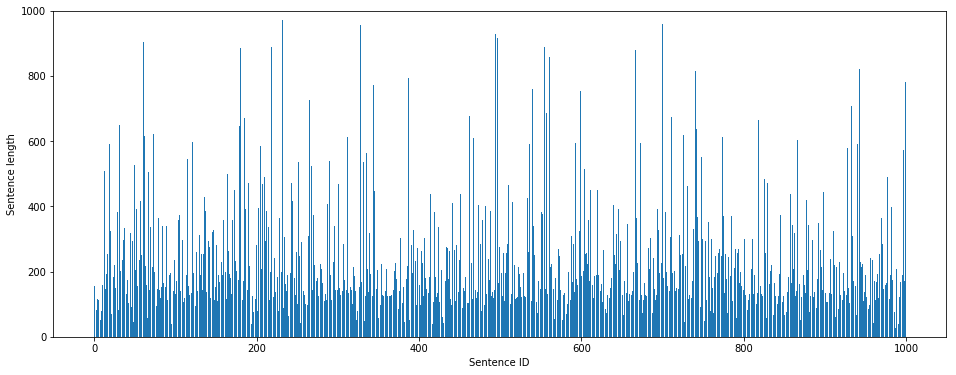

In [24]:
n_sent = 1000
plt.figure(figsize=(16,6))
plt.bar(np.arange(0, len(sample_seqs[:n_sent])), [len(seq) for seq in sample_seqs[:n_sent]], 0.8)
plt.ylim([0, 1000])
plt.ylabel("Sentence length")
plt.xlabel("Sentence ID")

## Padding sentences

Let's see if long sentences have been truncated and short sentences have been padded.

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(sample_seqs, maxlen=200, padding='pre', truncating='pre')

idx = 7 
print("Sentence length before padding: {} / after padding: {}".format(len(sample_seqs[idx]), len(padded[idx])))
idx = 2
print("Sentence length before padding: {} / after padding: {}".format(len(sample_seqs[idx]), len(padded[idx])))

Sentence length before padding: 583 / after padding: 200
Sentence length before padding: 66 / after padding: 200


## Converting sequence IDs back to words

As said previously the `Tokenizer` object offers an attribute called `index_word` which can be used to convert sequence IDs back to words. You'll note that rare words have been replaced with the token `<unk>`.

In [9]:
seq = tok.texts_to_sequences([sample_text[0]])
print(seq[0])
print()
words = [tok.index_word[i] for i in seq[0]]
print(' '.join(words))

[10, 148, 35, 11, 18, 55, 159, 10, 92, 1, 621, 1, 52, 74, 8, 11, 18, 23, 65, 148, 68, 457, 218, 1, 20, 2, 1, 1, 1, 3, 1, 1, 1, 1, 13, 474, 218, 5, 270, 2, 107, 8, 11, 18, 7, 629, 88, 41, 35, 12, 1, 1, 18, 9, 199, 13, 549, 8, 4, 601, 1, 1, 3, 10, 35, 2, 200, 411, 8, 9, 9, 89, 69, 278, 6, 1, 59, 202, 739, 411, 8, 357, 1, 47, 44, 176, 571, 12, 241, 43, 15, 4, 18, 3, 22, 2, 86, 528, 9, 718, 182, 12, 78, 197, 182, 95, 25, 571, 336, 584, 8, 262, 495, 44, 48, 839, 1, 70, 6, 595, 9, 77, 1, 182, 6, 26, 1, 47, 71, 647, 15, 123, 7, 22, 195, 14, 49, 20, 2, 86, 485, 14, 71, 100, 271, 47, 71, 25, 139, 7, 2, 111, 15, 182, 30, 177, 982]
i actually like this movie even though i don't <unk> james <unk> very much in this movie you can actually see several big <unk> on the <unk> <unk> <unk> and <unk> <unk> <unk> <unk> was already big of course the plot in this movie is simple its just like that <unk> <unk> movie it however was told in a light <unk> <unk> and i like the comedy moments in it it made me tryi

## More on TensorFlow 2.0

TensorFlow 2.0 took a major turn from TF 1.0 as they realized the need to allow dynamic graph creation instead of asking the user to create the computational graph. TF 2.0 introduces several changes such as,

* Getting rid of `tf.placeholder`, `tf.variable_scope`
* Introducing `AutoGraph` feature
* Enabling eager execution by default

## Eager execution in TF

Eager execution allows TensorFlow to execute its operations immediately as soon as they are defined. In TF 1.0 it was done through a `Session` object.

In [1]:
import tensorflow as tf

In [4]:
tf_a = tf.constant([0, 1, 2, 3, 4, 5])
# Define tf_b as the result of adding 2 to tf_a
tf_b = _____
# Print tf_b
print(____)
tf.print(tf_b)

tf.Tensor([2 3 4 5 6 7], shape=(6,), dtype=int32)
[2 3 4 5 6 7]


## How does `AutoGraph` work?

AutoGraph feature builds TensorFlow data flow graphs dynamically by analyzing Python functions. In order for TensorFlow to know to build the graph, you need to decorate that with `tf.function` decorator.

In [3]:
@tf.function
def do_silly_computation(a, b, c):
    # Return a + (b*c)

tf_a = tf.constant([0,1,2,3])
tf_b = tf.constant([-0,-1,-2,-3])
tf_c = tf.constant([10,11,12,13])

print(do_silly_computation(tf_a, tf_b, tf_c))

tf.Tensor([  0 -10 -22 -36], shape=(4,), dtype=int32)
